In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import json
import warnings
import re
import os
warnings.filterwarnings('ignore')

In [2]:
normalization=False
folder = "uniform_eq_results"
course = 'epfl_algebrelineaire'

## Helper functions

In [3]:
'''This function calculates the mean value across weeks for each feature'''

def construct_mean_df(df):
    df_mean = df.copy()
    df_mean.columns = [x.split('_InWeek')[0] for x in df.columns]
    df_mean = df_mean.fillna(0)
    df_mean = df_mean.astype(float)
    df_mean = df_mean.mean(axis=1, level=0)
#     df_mean.to_csv("./visualization/{}/{}_mean_df.csv".format(course, method))
    return df_mean

In [4]:
'''
This function calculates the percentage importance, 
i.e. if importance <0, perc_importance = -(import / min_import)
    if importance >0, perc_importance = (import / max_import)
Also, this function plots the top 2 features with highest / lowest perc_importance
'''

def plot_top2(mean_df, method, course):
    sort_df = pd.DataFrame(mean_df.mean(axis=0).sort_values(ascending=True))
    sort_df = sort_df.reset_index()
    sort_df.columns = ['feature', 'importance']
#     sort_df['log_importance'] = np.log(abs(sort_df['importance']))
    sign_ip = np.where(sort_df['importance'].values >=0, 1, sort_df['importance'].values)
    sign_ip = np.where(sign_ip <0, -1, sign_ip)
#     sort_df['log_importance'] = sort_df['log_importance']*sign_ip
    sort_df['pn'] = sign_ip
    sort_df['perc_importance'] = sort_df['importance'].apply(lambda x: -x/sort_df.iat[0, 1] if x<0 
                                                             else x/sort_df.iat[-1, 1])
    sort_df.to_csv("./visualization/{}/{}_perc_df.csv".format(course, method))

    # plot
    plt.figure(figsize=(8,5))
    color=['red', 'red', 'green', 'green']
    sns.barplot(y='feature', x='perc_importance', data=sort_df.iloc[[0, 1, -2, -1]], palette=color)
    plt.axvline(x=0)
    plt.xticks([], rotation = 75, fontsize=15)
    plt.title('{}-{} most important features'.format(course, method), fontsize=20)
    max_impo = max(abs(sort_df.iat[0, 2]), abs(sort_df.iat[-1, 2]))
    plt.xlim([-max_impo, max_impo])
#     plt.xscale('symlog')
    plt.yticks(fontsize=12)
    plt.ylabel('')
    
    path = "./visualization/{}/".format(course)
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig("./visualization/{}/{}.png".format(course, method), bbox_inches = 'tight')
    return sort_df


In [5]:
'''Given selected features, this function plots the perc_important features for a single course and method'''

def plot_pool_importance(selected_features, sorted_df, course, method):
    left_df = pd.DataFrame({'feature': selected_features})
    sub_sort_df = left_df.merge(sorted_df, left_on='feature',right_on='feature', how='left')
    sub_sort_df.fillna(0, inplace=True)
    
    # plot
    plt.figure(figsize=(5,8))
    clrs = ['red' if (x < 0) else 'green' for x in sub_sort_df['perc_importance'] ]
#     palette ={-1: "red", 0: "black", 1: "green"}
    sns.barplot(y='feature', x='perc_importance', palette=clrs, data=sub_sort_df)
    plt.axvline(x=0)
    plt.xticks([], rotation = 90, fontsize=15)

    # plt.title('{}-{} most important features'.format(course, method), fontsize=20)
    # max_impo = max(abs(sort_df.iat[0, 2]), abs(sort_df.iat[-1, 2]))
    plt.xlim([-1, 1])
    #     plt.xscale('symlog')
    plt.yticks(fontsize=12)
    plt.legend([],[], frameon=False)
    plt.ylabel('')
    plt.xlabel('')
    
    path = "./visualization/{}/".format(course)
    if not os.path.exists(path):
        os.makedirs(path)
    plt.savefig("./visualization/{}/{}_pool.png".format(course, method), bbox_inches = 'tight')
    
    return sub_sort_df

In [6]:
'''Given course, this function plots perc_importance for all three methods
you choose the methods sequence
md1, md2, md3 in ['shap', 'lime', 'cem']
'''

def plot_pool_all(course_dict, md1, md2, md3):
    df = pd.concat([course_dict['shap_pool_sort_df'], 
                    course_dict['lime_pool_sort_df'], course_dict['cem_pool_sort_df']], 
          axis=1, keys=['shap', 'lime', 'cem'])
    df.columns = ["_".join(a) for a in df.columns.to_flat_index()]
    df['feature'] = df['shap_feature'].replace(feature_dict)
    
    palette ={-1: "red", 0: "black", 1: "green"}

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, constrained_layout=True, sharey=True, figsize=(18, 10))

    clrs = ['red' if (x < 0) else 'green' for x in df['{}_perc_importance'.format(md1)] ]
#     sns.set_theme(style="darkgrid")
    sns.barplot(y='feature', x='{}_perc_importance'.format(md1), palette=clrs, data=df, ax=ax1)
    ax1.axvline(x=0)
    ax1.legend([],[], frameon=False)
    ax1.set_title('Method 1', fontsize=20)
    ax1.set_xlabel('Importance', fontsize=16)
    ax1.set_ylabel('')
    ax1.set_xticks([])
    ax1.tick_params('y', labelsize=18)
    ax1.grid(axis = 'y')

    clrs = ['red' if (x < 0) else 'green' for x in df['{}_perc_importance'.format(md2)] ]
#     sns.set_theme(style="whitegrid")
    sns.barplot(y='feature', x='{}_perc_importance'.format(md2), palette=clrs, data=df, ax=ax2)
    ax2.axvline(x=0)
    ax2.legend([],[], frameon=False)
    ax2.set_title('Method 2', fontsize=20)
    ax2.set_xlabel('Importance', fontsize=16)
    ax2.set_ylabel('')
    ax2.set_xticks([])
    ax2.grid(axis = 'y')

    clrs = ['red' if (x < 0) else 'green' for x in df['{}_perc_importance'.format(md3)] ]
#     sns.set_theme(style="whitegrid")
    sns.barplot(y='feature', x='{}_perc_importance'.format(md3), palette=clrs, data=df, ax=ax3)
    ax3.axvline(x=0)
    ax3.legend([],[], frameon=False)
    ax3.set_title('Method 3', fontsize=20)
    ax3.set_xlabel('Importance', fontsize=16)
    ax3.set_ylabel('')
    ax3.set_xticks([])
    ax3.grid(axis = 'y')
    
#     plt.savefig("./visualization/{}/{}_pool.png".format(course, method), bbox_inches = 'tight')
    
    return

In [7]:
'''This function is used to clean lime column name, the output is a list with only feature names'''

def clean_lime_col_name(ori_cols):
    new_cols = []
    for x in ori_cols:
        x_l = x.split(' ')
        for m in x_l:
            if m[0].isalpha():
                new_cols.append(m)
                continue
    return new_cols

In [8]:
'''This function is used to load lime original results'''

def dataframe_all_lime(folder, course):
    instances = np.load('uniform_data/uniform_'+course+'.npy')
    inst = instances[0]

    instance_file = folder + "/LIME/" + course + "/dataframes/" + str(inst) + ".csv"
    inst_df = pd.read_csv(instance_file, header=0)
    inst_df.columns = ['feature', 'score']
    inst_df['inst'] = inst
    
    for inst in instances[1:]:
        instance_file = folder + "/LIME/" + course + "/dataframes/" + str(inst) + ".csv"
        inst_temp = pd.read_csv(instance_file, header=0)
        inst_temp.columns = ['feature', 'score']
        inst_temp['inst'] = inst
        inst_df = pd.concat([inst_df, inst_temp])
    
    inst_df = inst_df.drop_duplicates()
    df = inst_df.pivot(columns='feature', values='score', index='inst')
    df.to_csv("./visualization/{}/lime.csv".format(course))
    return df

In [9]:
'''This function is used to load cem original results'''

def load_cem_ori_res(course):
    # load original CEM result matrix
    path = folder + "/CEM/" + course + "/changes_pn.npy"
    mt = np.load(path)
    print(mt.shape)
    
    # get sign_mt
    sign_mt = np.where(mt >=0, 1, mt)
    sign_mt = np.where(sign_mt <0, -1, sign_mt)
    
    # load abs CEM dataframe
    extract_file = folder + "/CEM/" + course + "/importances.csv"
    cem_df = pd.read_csv(extract_file, header=0)
    print(cem_df.shape)
    
    df = cem_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = False) * sign_mt
    df.to_csv("./visualization/{}/cem.csv".format(course))
    return df

In [10]:
'''This function get mean of min-max normalized score across three methods'''

def get_mean_score_norm(lime_df, shap_df, cem_df):
    lime_df.fillna(0, inplace=True)
    lime_df = lime_df.astype(float)
    normalized_lime_df=(lime_df-lime_df.min())/(lime_df.max()-lime_df.min())
    normalized_lime_df = normalized_lime_df.div(normalized_lime_df.sum(axis=1), axis=0)
    normalized_lime_df = normalized_lime_df.fillna(0)
    
    cem_df.fillna(0, inplace=True)
    cem_df = cem_df.astype(float)
    normalized_cem_df=(cem_df-cem_df.min())/(cem_df.max()-cem_df.min())
    normalized_cem_df = normalized_cem_df.div(normalized_cem_df.sum(axis=1), axis=0)
    normalized_cem_df = normalized_cem_df.fillna(0)
    
    shap_df.fillna(0, inplace=True)
    shap_df = shap_df.astype(float)
    normalized_shap_df=(shap_df-shap_df.min())/(shap_df.max()-shap_df.min())
    normalized_shap_df = normalized_shap_df.div(normalized_shap_df.sum(axis=1), axis=0)
    normalized_shap_df = normalized_shap_df.fillna(0)
    
    # get mean
    normalized_shap_df_mean = normalized_shap_df.mean().reset_index()
    normalized_shap_df_mean.columns = ['feature', 'mean_score']
    normalized_lime_df_mean = normalized_lime_df.mean().reset_index()
    normalized_lime_df_mean.columns = ['feature', 'mean_score']
    normalized_cem_df_mean = normalized_cem_df.mean().reset_index()
    normalized_cem_df_mean.columns = ['feature', 'mean_score']
    
    df = normalized_shap_df_mean.merge(normalized_cem_df_mean, 
                                   left_on='feature', right_on='feature', how='outer', 
                                   suffixes=['_shap', '_cem'])
    df = df.merge(normalized_lime_df_mean, 
                  left_on='feature', right_on='feature', how='outer')
    df.rename(columns={"mean_score": "mean_score_lime"}, inplace=True)
    df.fillna(0, inplace=True)
    
    df.to_csv("./visualization/{}/mean_score_norm.csv".format(course))
    
    return df, normalized_lime_df, normalized_cem_df, normalized_shap_df

In [11]:
'''This function reture a sorted dataframe that contains the score diffs between a pair of courses'''

def compare_period(course1_dict, course2_dict, 
                   start_1, mid_1, end_1, 
                   start_2, mid_2, end_2):
    time_dict1 = dict()
    for n in start_1:
        time_dict1[str(n)] = 'start'
    for n in mid_1:
        time_dict1[str(n)] = 'mid'
    for n in end_1:
        time_dict1[str(n)] = 'end'

    c1_mean_time_df = course1_dict['mean_norm_df'].copy()
    c1_mean_time_df['mean_score'] = c1_mean_time_df[['mean_score_shap', 
                                                    'mean_score_cem', 'mean_score_lime']].mean(axis=1)
    c1_mean_time_df['week'] = [x.split('_InWeek')[1] for x in c1_mean_time_df.feature]
    c1_mean_time_df['period'] = c1_mean_time_df['week'].replace(time_dict1)
    c1_mean_time_df['feature_clean'] = [x.split('_InWeek')[0] for x in c1_mean_time_df.feature]
    c1_period_df = c1_mean_time_df.groupby(by=['period', 'feature_clean'], as_index=False).mean()
    c1_mean_df = c1_mean_time_df.groupby(by=['feature_clean'], as_index=False).mean()
    
    time_dict2 = dict()
    for n in start_2:
        time_dict2[str(n)] = 'start'
    for n in mid_2:
        time_dict2[str(n)] = 'mid'
    for n in end_2:
        time_dict2[str(n)] = 'end'

    c2_mean_time_df = course2_dict['mean_norm_df'].copy()
    c2_mean_time_df['mean_score'] = c2_mean_time_df[['mean_score_shap', 
                                                    'mean_score_cem', 'mean_score_lime']].mean(axis=1)
    c2_mean_time_df['week'] = [x.split('_InWeek')[1] for x in c2_mean_time_df.feature]
    c2_mean_time_df['period'] = c2_mean_time_df['week'].replace(time_dict2)
    c2_mean_time_df['feature_clean'] = [x.split('_InWeek')[0] for x in c2_mean_time_df.feature]
    c2_period_df = c2_mean_time_df.groupby(by=['period', 'feature_clean'], as_index=False).mean()
    c2_mean_df = c2_mean_time_df.groupby(by=['feature_clean'], as_index=False).mean()
    
    compare_period = c1_period_df.merge(c2_period_df, 
                        left_on=['period', 'feature_clean'], right_on=['period', 'feature_clean'], 
                        how='inner', suffixes=['_1', '_2'])
    compare_period['diff'] = compare_period['mean_score_1'] - compare_period['mean_score_2']
    compare_period = compare_period.sort_values(by = 'diff', ascending=True).dropna()
    
    compare_feature = c1_mean_df.merge(c2_mean_df, 
                        left_on=['feature_clean'], right_on=['feature_clean'], 
                        how='inner', suffixes=['_1', '_2'])
    compare_feature['diff'] = compare_feature['mean_score_1'] - compare_feature['mean_score_2']
    compare_feature = compare_feature.sort_values(by = 'diff', ascending=True).dropna()
    
    return compare_period, compare_feature

In [12]:
# feature dict for a more understandable name
feature_dict = {
    'NumberSubmissions-avg': 'num-submit-quiz',
    'WatchingRatio': 'finish-watch-ratio-vid',
    'SpeedPlayback-mean': 'speed-vid',
    'NumberSubmissions-distinct': 'distinct-probs-quiz', 
    'number_submissions_distinct': 'distinct-probs-quiz',
    'StudentWeeklyActiveness': 'active-participation-weekly-vid',
    'ObsDurationProblem-max': 'correct-time-quiz',
    'video.play-video.stop-video.play': 'play-stop-play-vid',
    'SeekLength-mean': 'avg-len-ffw-vid',
    'problem.check-problem.check-problem.check': 'check-check-check-quiz',
    'FrequencyEvent-video.play-played': 'freq-play-vid',
    'RegPeriodicity-m1': 'hourly-freq-regular',
    'time_sessions_std': 'std-time-session',
    'ratio_clicks_weekend_day': 'ratio-clicks-weekend',
    'obs_duration_problem_var': 'std-correct-time-quiz',
    'competency_anticipation': 'eager-view-quiz',
    'time_in__video_sum': 'total-time-vid',
    'frequency_action_Video.Pause': 'freq-pause-vid'
}

In [13]:
# store selected features 
# which are gained by just look at the top positive & negative features from each methods 

modality_selected_features = ['video.play-video.stop-video.play', 'SeekLength-mean', 'WatchingRatio', 
                              'SpeedPlayback-mean', 'StudentWeeklyActiveness', 
                              'FrequencyEvent-video.play-played', 
                              'NumberSubmissions-avg', 'NumberSubmissions-distinct', 'ObsDurationProblem-max', 
                              'problem.check-problem.check-problem.check', 'RegPeriodicity-m1']

AL_selected_features = ['time_in__video_sum', 'frequency_action_Video.Pause', 
                        'number_submissions_distinct', 'obs_duration_problem_var', 
                        'competency_anticipation', 'problem.check-problem.check-problem.check', 
                        'time_sessions_std', 'ratio_clicks_weekend_day']


# MOOC FP

In [14]:
course = 'progfun_005'
mooc_FP = dict()

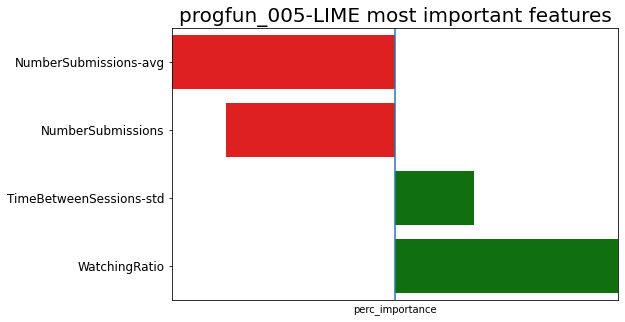

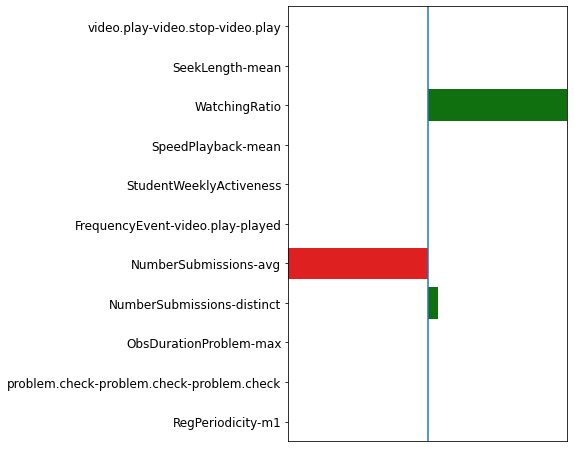

In [15]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
mooc_FP['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
mooc_FP['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
mooc_FP['lime_sort_df'] = lime_sort_df
mooc_FP['lime_pool_sort_df'] = plot_pool_importance(modality_selected_features, 
                                               lime_sort_df, course, 'lime')

**NumberSubmissions-avg**: The number of submissions performed for a quiz, on average. \
**NumberSubmissions**: The (statistics) on the number of problem submissions made by a student \
**TimeBetweenSessions-std**: The std of (statistics) on the time between sessions \
**WatchingRatio**: With attendance and utilization rate, the student’s overall specialty watching ratio is defined. The wathing ratio represents how student watches the video since he/she opened it. For instance, watching_ratio=1 means that the student s completely watches the video since he/ she opened it.

(99, 512)
(99, 514)


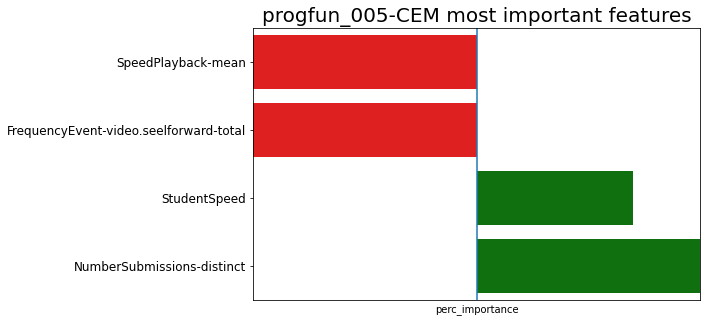

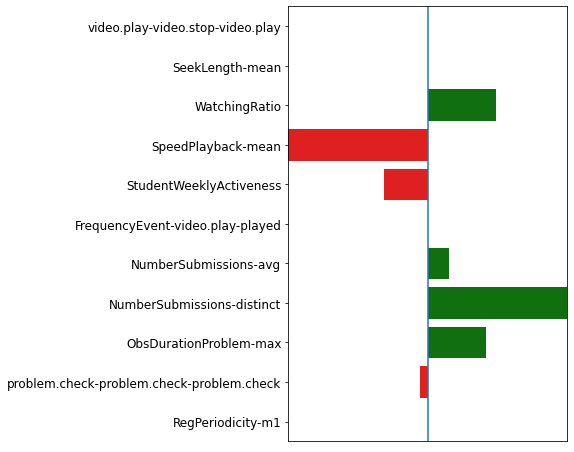

In [16]:
cem_df = load_cem_ori_res(course)
mooc_FP['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
mooc_FP['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
mooc_FP['cem_sort_df'] = cem_sort_df
mooc_FP['cem_pool_sort_df'] = plot_pool_importance(modality_selected_features, 
                                               cem_sort_df, course, 'cem')

**SpeedPlayback-mean**: The average speed the student used to play back a video. \
**FrequencyEvent-video.seelforward-total**:  The frequency between every Video.SeekForward action and the following action. \
**StudentSpeed**: The average time passed between two consecutive attempts for the same quiz. \
**NumberSubmissions-distinct**: The total number of distinct problems attempted by the student. 

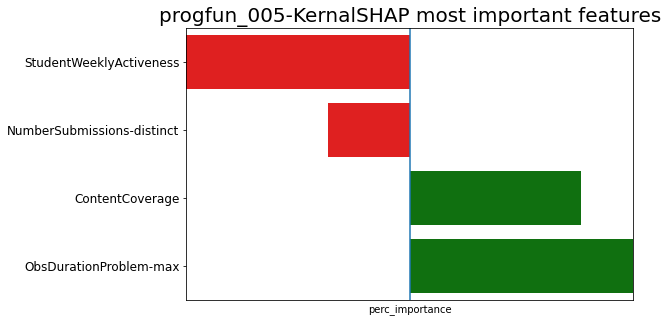

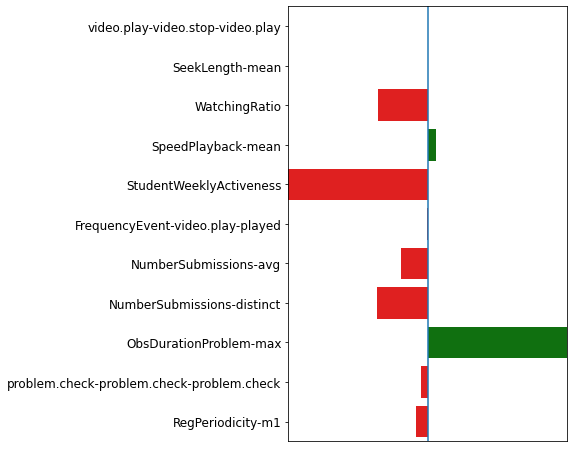

In [17]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
mooc_FP['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
mooc_FP['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
mooc_FP['shap_sort_df'] = shap_sort_df
mooc_FP['shap_pool_sort_df'] = plot_pool_importance(modality_selected_features, 
                                               shap_sort_df, course, 'shap')

**StudentWeeklyActiveness**: The number of videos the student watched in their entirety divided by the number of loaded videos by the student. -- student activeness. \
**NumberSubmissions-distinct**: The total number of distinct problems attempted by the student.\
**ContentCoverage**: The number of videos covered by the student since the beginning of the course. \
**ObsDurationProblem-max**: Total time spent divided by the number of correct problems.

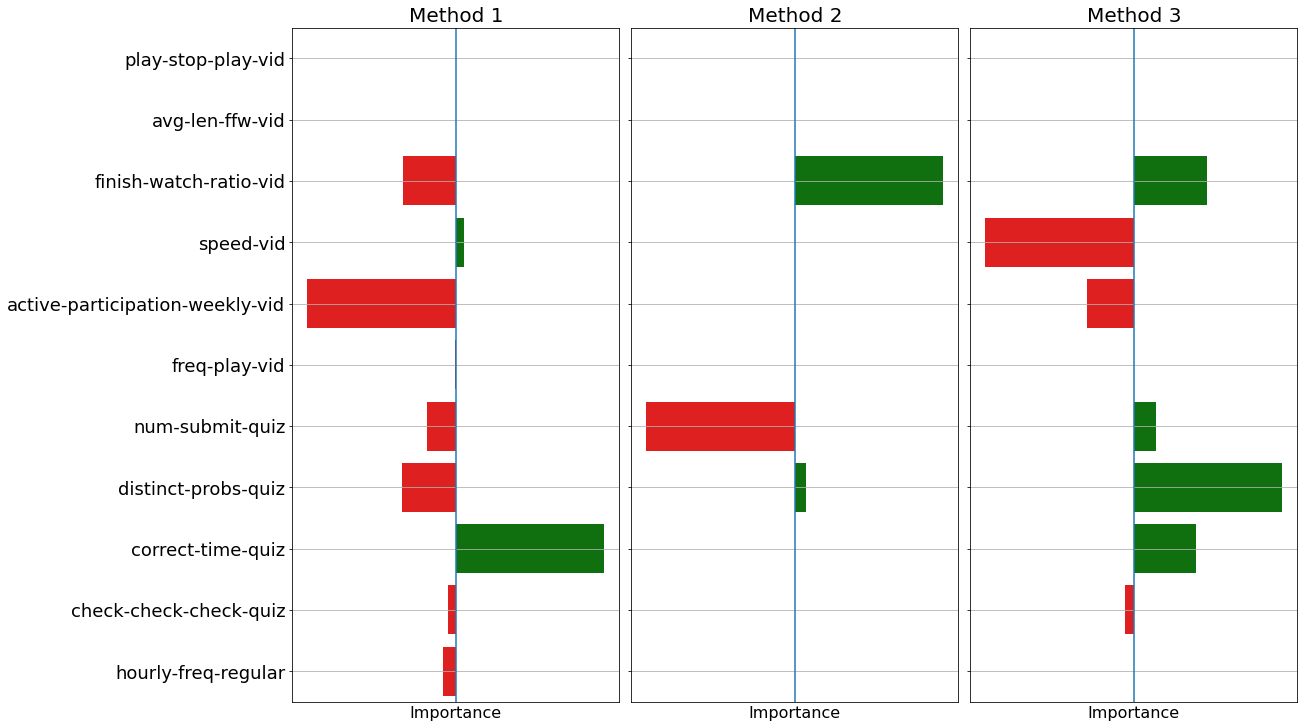

In [18]:
plot_pool_all(mooc_FP, 'shap', 'lime', 'cem')

In [19]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
mooc_FP['mean_norm_df'] = mean_norm_df
mooc_FP['norm_lime_df'] = norm_lime_df
mooc_FP['norm_cem_df'] = norm_cem_df
mooc_FP['norm_shap_df'] = norm_shap_df

In [20]:
mooc_FP['mean_norm_df']

,feature,mean_score_shap,mean_score_cem,mean_score_lime
0,TotalClicks_InWeek1,0.001403,0.002220,0.000000
1,NumberSessions_InWeek1,0.003066,0.000365,0.000000
2,Time-video-sum_InWeek1,0.003385,0.003360,0.000000
3,Time-problem-sum_InWeek1,0.000843,0.003606,0.000000
4,video.pause-video.speedchange-video.play_InWeek1,0.000614,0.001707,0.000000
...,...,...,...,...
517,NumberSubmissions-avg_time_InWeek8,0.000000,0.000000,0.016475
518,TimeSolveProblem_InWeek8,0.000985,0.001507,0.000000
519,ObsDurationProblem-var_InWeek8,0.000369,0.005376,0.000000
520,ObsDurationProblem-max_InWeek8,0.000302,0.001146,0.000000


# Flip FP

In [21]:
course = 'epfl_cs_210_2018_t3'
Flip_FP = dict()

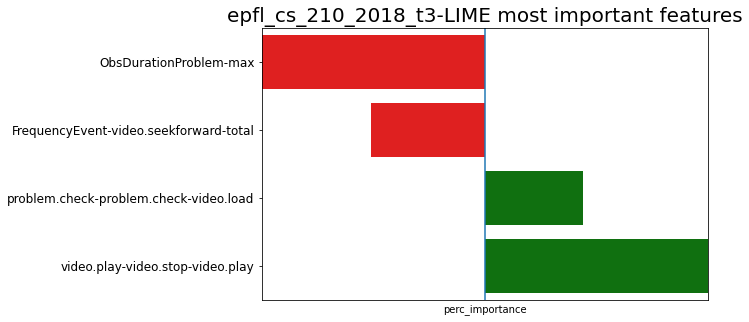

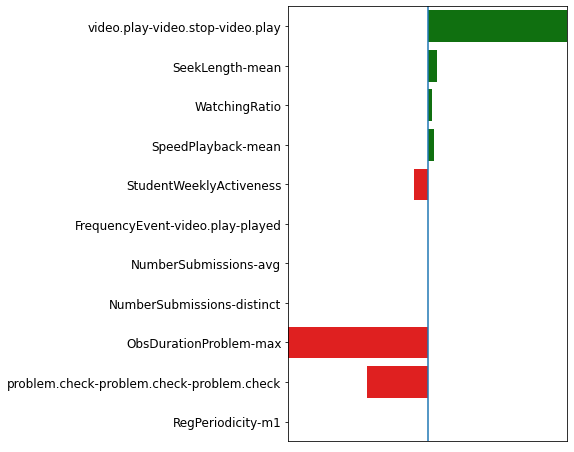

In [22]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
Flip_FP['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
Flip_FP['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
Flip_FP['lime_sort_df'] = lime_sort_df
Flip_FP['lime_pool_sort_df'] = plot_pool_importance(modality_selected_features, 
                                               lime_sort_df, course, 'lime')

**ObsDurationProblem-max**: Total time spent divided by the number of correct problems. \
**FrequencyEvent-video.seelforward-total**: The frequency between every Video.SeekForward action and the following action. \
**QCheck-QCheck-VLoad**: The amount of times the student checks twice the quiz and then go to load a video. \
**VPlay-VStop-VPlay**: The amount of times the student plays a video, stops, and plays another one. 

(100, 1136)
(100, 1138)


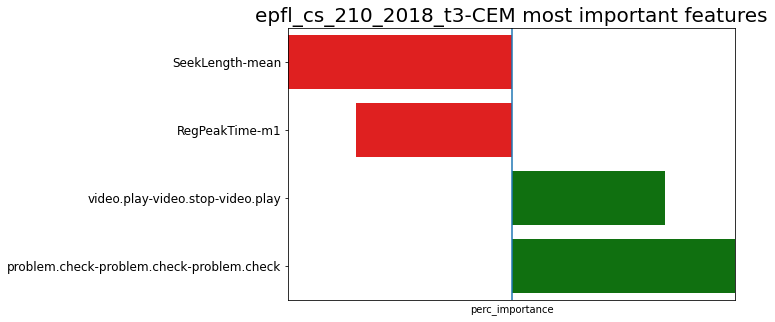

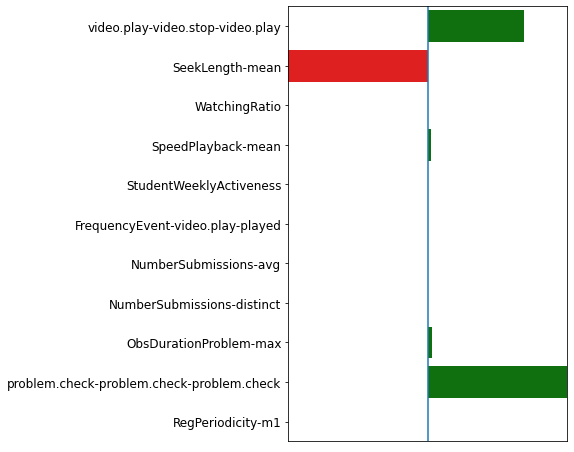

In [23]:
cem_df = load_cem_ori_res(course)
Flip_FP['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
Flip_FP['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
Flip_FP['cem_sort_df'] = cem_sort_df
Flip_FP['cem_pool_sort_df'] = plot_pool_importance(modality_selected_features, 
                                               cem_sort_df, course, 'cem')

**SeekLength-mean**: The student’s average seek length (seconds). \
**RegPeakTime-m1**: Two measures, PDH and PWD, based on the entropy of the histogram of user’s activitiy over time. \
    - PDH identifies if user’s activities are concentrated around a particular hour of the day. \
    - PWD determines if activities are concentrated around a particular day of the week. \
**video.play-video.stop-video.play**: The amount of times the student plays a video, pause and then load another one. \
**problem.check-problem.check-problem.check**:  The amount of times the student checks three times the same quiz.

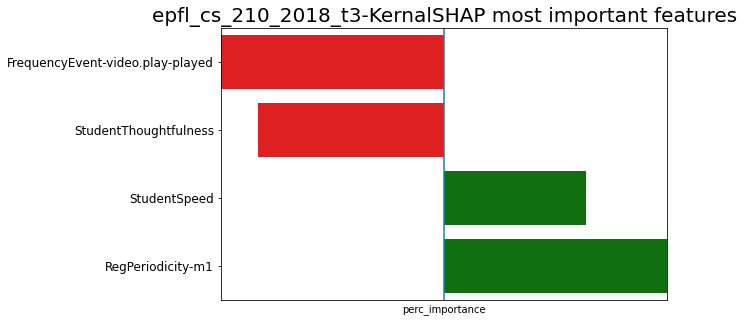

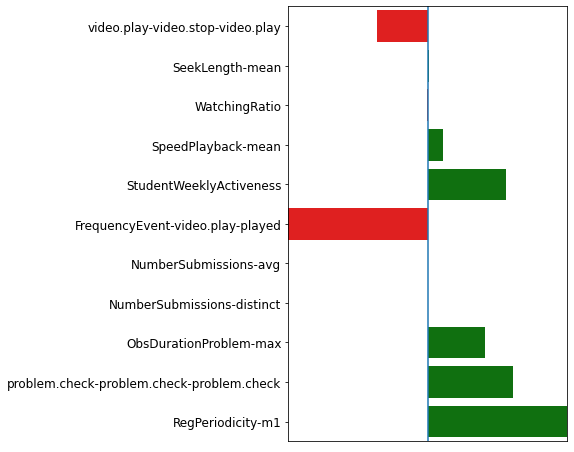

In [24]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
Flip_FP['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
Flip_FP['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
Flip_FP['shap_sort_df'] = shap_sort_df
Flip_FP['shap_pool_sort_df'] = plot_pool_importance(modality_selected_features, 
                                               shap_sort_df, course, 'shap')

**FrequencyEvent-video.play-played**: The frequency of the play event in the students’ sessions. \
**StudentThoughtfulness**: The amount of time passed reflecting on pause during a video. \
**StudentSpeed**: The average amount of time passed between two submissions for the attempted quizzes. \
**RegPeriodicity-m1**: Three frequency based measures, FDH, FWH and FWD as 
- FDH measures the extent to which the hourly pattern of user’s activities is repeating over days (e.g. the user is active at 8h-10h and 12h-17h on every day).
- FWH identifies if the hourly pattern of activities is repeating over weeks (e.g. in every week, the user is active at 8h-10h on Monday, 12h-17h on Tuesdays, etc.).
- FWD captures if the daily pattern of activities is repeating over weeks (e.g. the user is active on Monday and Tuesday in every week).

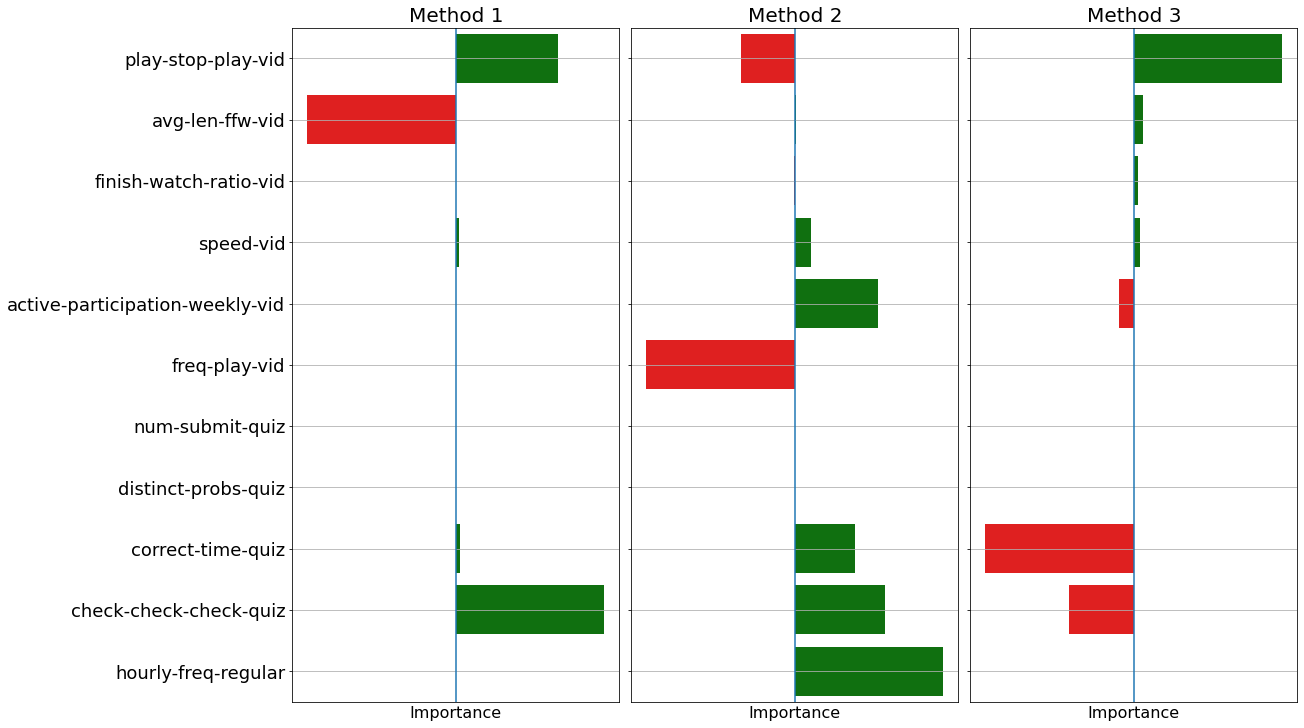

In [25]:
plot_pool_all(Flip_FP, 'cem', 'shap', 'lime')

In [26]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
Flip_FP['mean_norm_df'] = mean_norm_df
Flip_FP['norm_lime_df'] = norm_lime_df
Flip_FP['norm_cem_df'] = norm_cem_df
Flip_FP['norm_shap_df'] = norm_shap_df

In [27]:
Flip_FP['mean_norm_df']

,feature,mean_score_shap,mean_score_cem,mean_score_lime
0,TotalClicks_InWeek1,0.001142,0.001445,0.000000
1,NumberSessions_InWeek1,0.000789,0.001749,0.000000
2,Time-video-sum_InWeek1,0.001240,0.002013,0.000000
3,Time-problem-sum_InWeek1,0.000873,0.001961,0.000000
4,video.pause-video.speedchange-video.play_InWeek1,0.001994,0.000321,0.000000
...,...,...,...,...
1133,FrequencyEvent-video.load-relative_InWeek16,0.000000,0.000000,0.008038
1134,TimeSolveProblem_InWeek16,0.000000,0.000000,0.008029
1135,ObsDurationProblem-var_InWeek16,0.000000,0.000175,0.007897
1136,ObsDurationProblem-max_InWeek16,0.000000,0.000162,0.007540


## Flipped FP vs MOOC FP

In [28]:
compare_per_mod, compare_feat_mod = compare_period(Flip_FP, mooc_FP, 
                                                   list(range(1,6)), list(range(6, 12)), list(range(12,17)), 
                                                   list(range(1,3)), list(range(7, 9)), list(range(3,7)))
display(compare_per_mod)
display(compare_feat_mod)
compare_per_mod.to_csv("./visualization/compare_period_md_FP.csv")
compare_feat_mod.to_csv("./visualization/compare_feature_md_FP.csv")

,period,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
0,end,AttendanceRate,0.000000,0.000000,0.001655,0.000552,0.003496,0.002429,0.009099,0.005008,-0.004456
108,mid,WeeklyProp-replayed-mean,0.000837,0.000668,0.000047,0.000517,0.001449,0.003008,0.008427,0.004295,-0.003777
59,mid,ContentAlignment,0.000770,0.000137,0.000201,0.000369,0.001972,0.000109,0.010273,0.004118,-0.003748
58,mid,AttendanceRate,0.000762,0.000170,0.000084,0.000339,0.001913,0.001470,0.008042,0.003808,-0.003469
60,mid,ContentAnticipation,0.000234,0.000251,0.003734,0.001406,0.000000,0.000402,0.014065,0.004822,-0.003416
...,...,...,...,...,...,...,...,...,...,...,...
171,start,video.play-problem.check-problem.check,0.000000,0.000156,0.007326,0.002494,0.004735,0.000023,0.000000,0.001586,0.000908
53,end,problem.check-problem.check-video.load,0.000912,0.000105,0.002742,0.001253,0.000766,0.000076,0.000087,0.000309,0.000944
7,end,FractionSpent-video.play-completed,0.000000,0.000166,0.007631,0.002599,0.001569,0.003251,0.000000,0.001607,0.000992
32,end,Time-problem-sum,0.000218,0.001216,0.003203,0.001546,0.000615,0.000897,0.000000,0.000504,0.001042


,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
0,AttendanceRate,0.000791,0.000234,0.000549,0.000525,0.002857,0.002470,0.006560,0.003962,-0.003437
1,ContentAlignment,0.000793,0.000424,0.000120,0.000446,0.002925,0.001258,0.002568,0.002250,-0.001805
51,WeeklyProp-watched-mean,0.000746,0.000243,0.000325,0.000438,0.002926,0.001584,0.001804,0.002104,-0.001666
33,Time-video-sum,0.000878,0.001682,0.000000,0.000853,0.003393,0.003891,0.000000,0.002428,-0.001575
30,StudentThoughtfulness,0.000885,0.000404,0.000005,0.000432,0.003144,0.002420,0.000000,0.001855,-0.001423
50,WeeklyProp-replayed-mean,0.000877,0.000645,0.000319,0.000614,0.001492,0.002301,0.002107,0.001967,-0.001353
37,TimeSessions-std,0.000677,0.000245,0.000375,0.000432,0.001346,0.002508,0.001495,0.001783,-0.001351
48,WatchingRatio,0.000655,0.000518,0.001051,0.000741,0.003555,0.000833,0.001739,0.002042,-0.001301
8,FractionSpent-video.play-played,0.000642,0.000459,0.001393,0.000831,0.001509,0.002767,0.001993,0.002090,-0.001259
23,PauseDuration-std,0.000545,0.000458,0.000726,0.000576,0.003668,0.001670,0.000000,0.001779,-0.001203


# AN

In [29]:
course = 'analysenumerique_002'
AN_2 = dict()

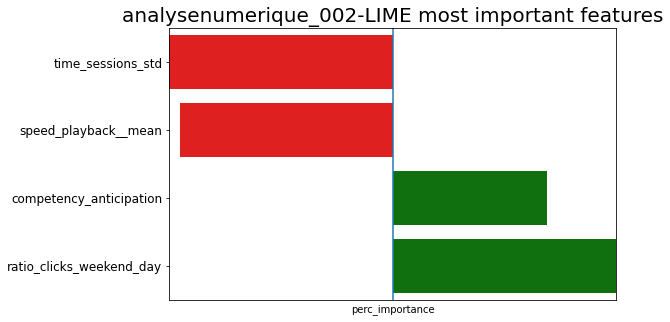

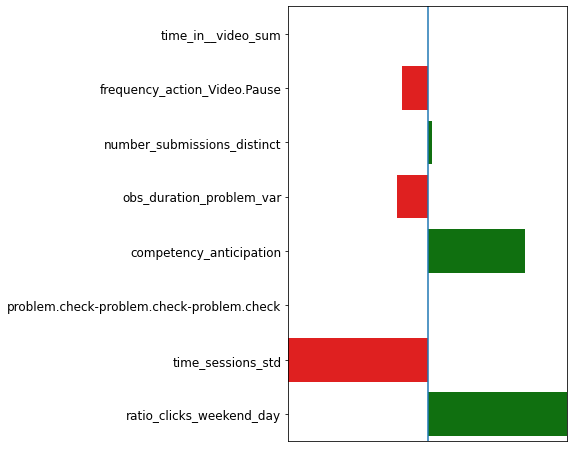

In [30]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
AN_2['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
AN_2['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
AN_2['lime_sort_df'] = lime_sort_df
AN_2['lime_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
                                               lime_sort_df, course, 'lime')

**time_sessions_std**: The standard deviation of time spent from a login to the end of the session. \
**speed_playback__mean**: The average speed the student used to play back a video. \
**competency_anticipation**: The extent to which the student approaches soon a quiz provided in subsequent weeks. \
**ratio_clicks_weekend_day**: The ratio between clicks in weekdays and weekends.

(100, 528)
(100, 530)


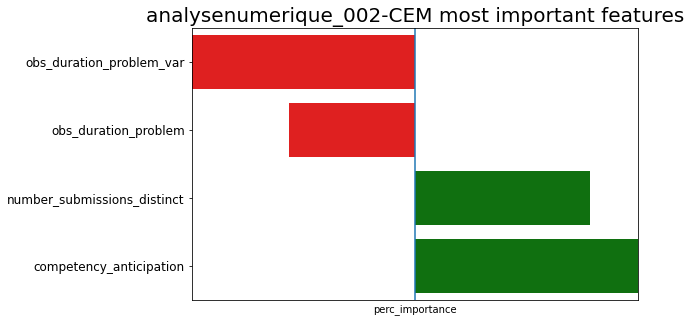

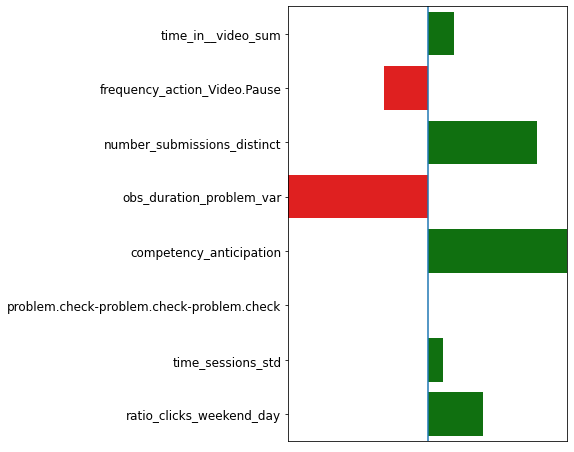

In [31]:
cem_df = load_cem_ori_res(course)
AN_2['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
AN_2['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
AN_2['cem_sort_df'] = cem_sort_df
AN_2['cem_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
                                               cem_sort_df, course, 'cem')

**obs_duration_problem_var**: Var of total time spent divided by the number of correct problems. \
**obs_duration_problem**: Total time spent divided by the number of correct problems. \
**number_submissions_distinct**: The total number of distinct problems attempted by the student. \
**competency_anticipation**: The extent to which the student approaches soon a quiz provided in subsequent weeks.

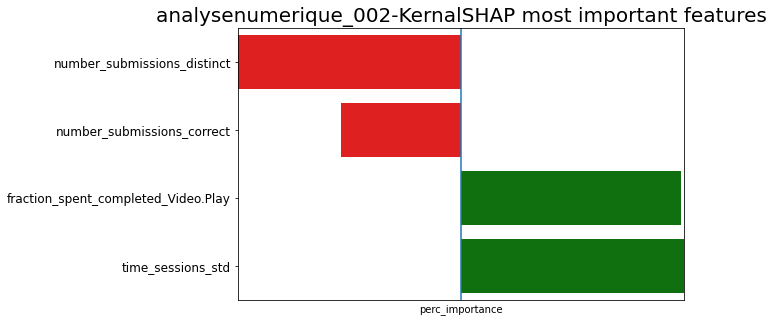

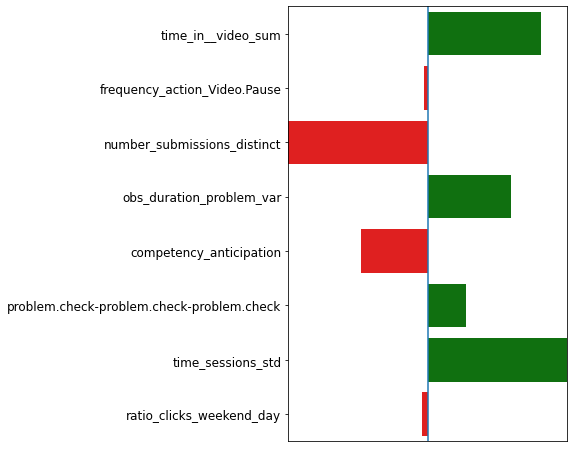

In [32]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
AN_2['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
AN_2['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
AN_2['shap_sort_df'] = shap_sort_df
AN_2['shap_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
                                               shap_sort_df, course, 'shap')

**number_submissions_distinct**: The total number of distinct problems attempted by the student. \
**number_submissions_correct**: The percentage of the correct quiz submissions with respect to the total submissions. \
**fraction_spent_completed_Video.Play**: The frequency between every Video.Play action and the following action. \
**time_sessions_std**: The standard deviation of student’s time in sessions.

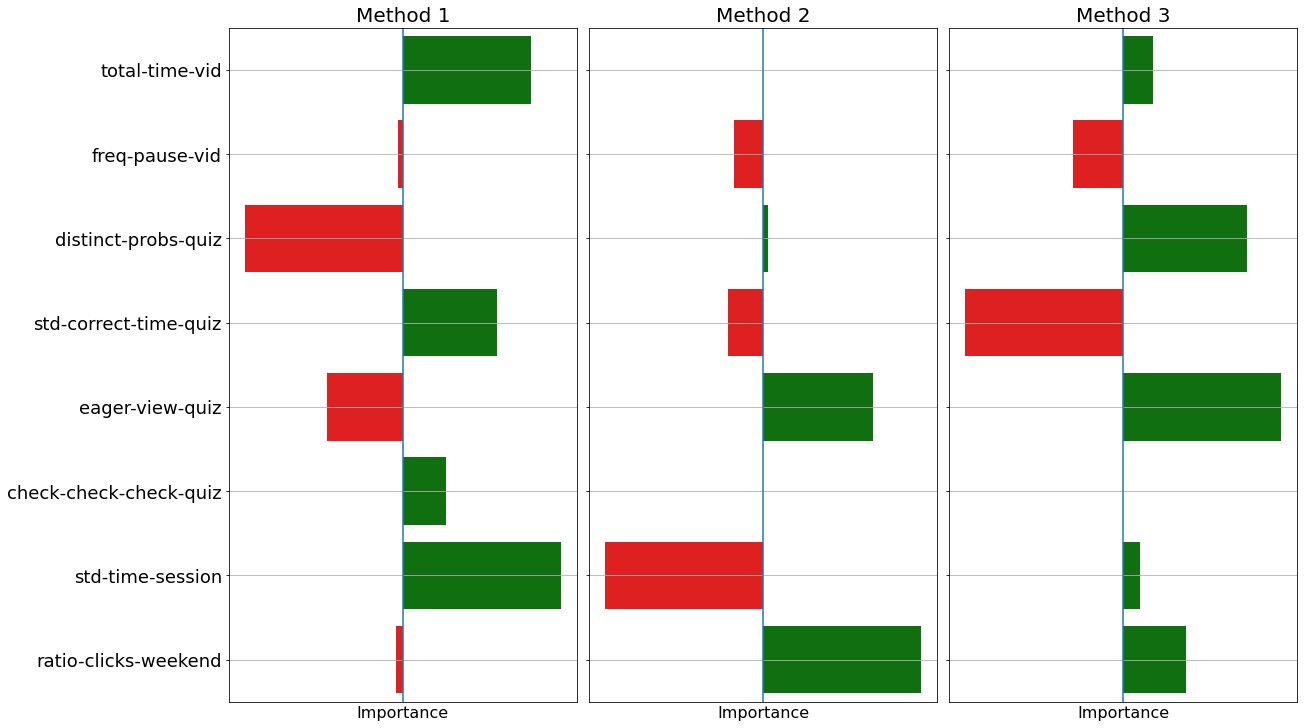

In [33]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
AN_2['mean_norm_df'] = mean_norm_df
AN_2['norm_lime_df'] = norm_lime_df
AN_2['norm_cem_df'] = norm_cem_df
AN_2['norm_shap_df'] = norm_shap_df
plot_pool_all(AN_2, 'shap', 'lime', 'cem')

# Geom

In [34]:
course = 'geomatique_003'
Geom = dict()

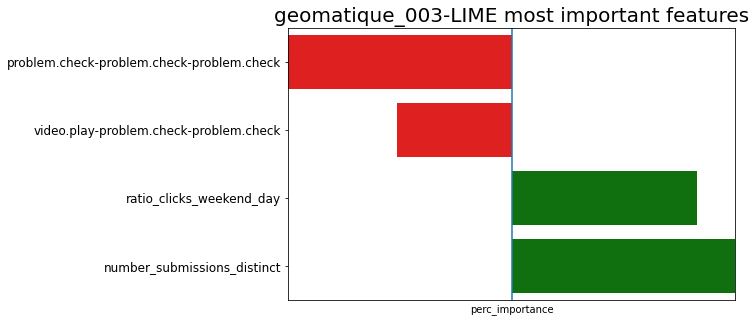

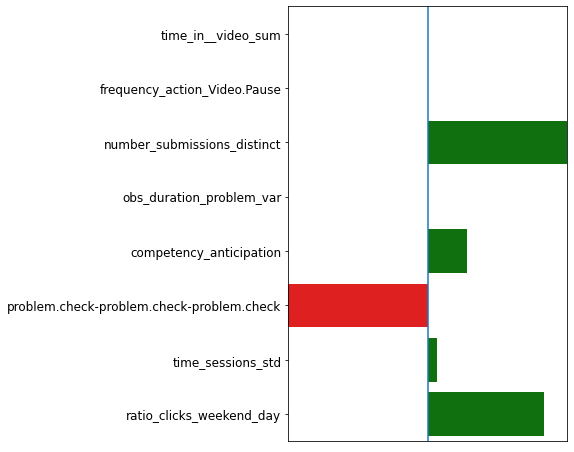

In [35]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
Geom['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
Geom['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
Geom['lime_sort_df'] = lime_sort_df
Geom['lime_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
                                               lime_sort_df, course, 'lime')

**problem.check-problem.check-problem.check**: The amount of times the student checks three times the same quiz. \
**video.play-problem.check-problem.check**: The amount of times the student plays a video, then checks twice a quiz. \
**ratio_clicks_weekend_day**: The ratio between the number of clicks in the weekend and the weekdays. \
**number_submissions_distinct**: The total number of distinct problems attempted by the student.

(100, 990)
(100, 992)


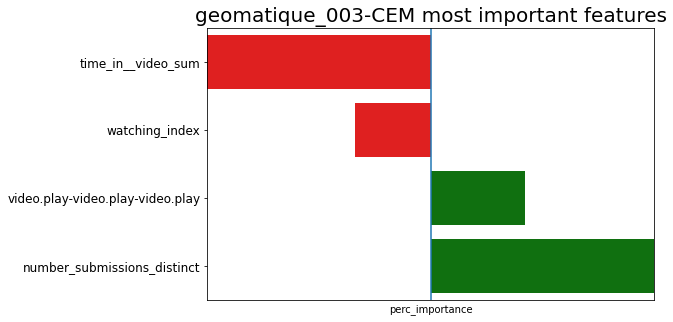

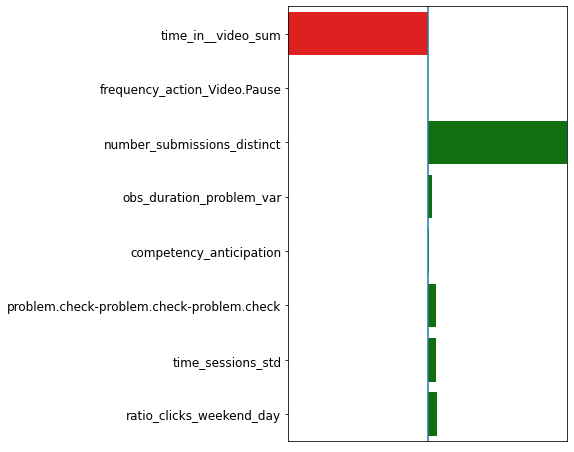

In [36]:
cem_df = load_cem_ori_res(course)
Geom['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
Geom['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
Geom['cem_sort_df'] = cem_sort_df
Geom['cem_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
                                               cem_sort_df, course, 'cem')

**time_in__video_sum**: The total (cumulative) time that a student has spent on video events. \
**watching_index**: The watching index is defined as utilization rate times attendance rate. \
**video.play-video.play-video.play**: The amount of times the student clicks for three consecutive times on play for three different videos. \
**number_submissions_distinct**:  The total number of distinct problems attempted by the student. 

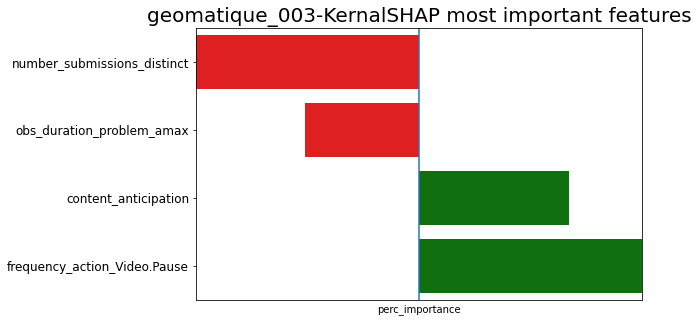

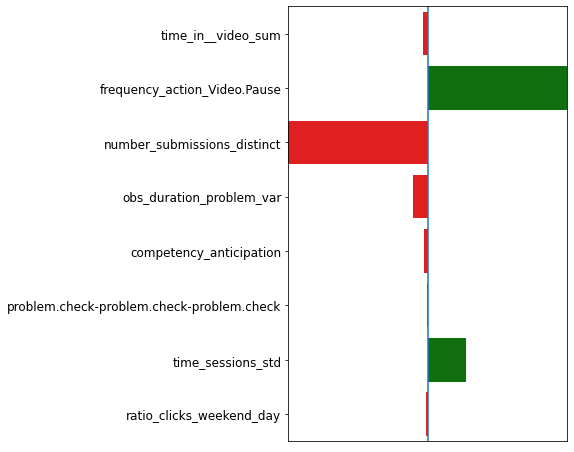

In [37]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
Geom['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
Geom['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
Geom['shap_sort_df'] = shap_sort_df
Geom['shap_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
                                               shap_sort_df, course, 'shap')

**number_submissions_distinct**: The total number of distinct problems attempted by the student. \
**obs_duration_problem_amax**: Total time spent divided by the number of correct problems. (obs_duration_problem) \
**content_anticipation**: The extent to which the student approaches soon a video provided in subsequent weeks. \
**frequency_action_Video.Pause**: The frequency between every Video.Pause action and the following action.

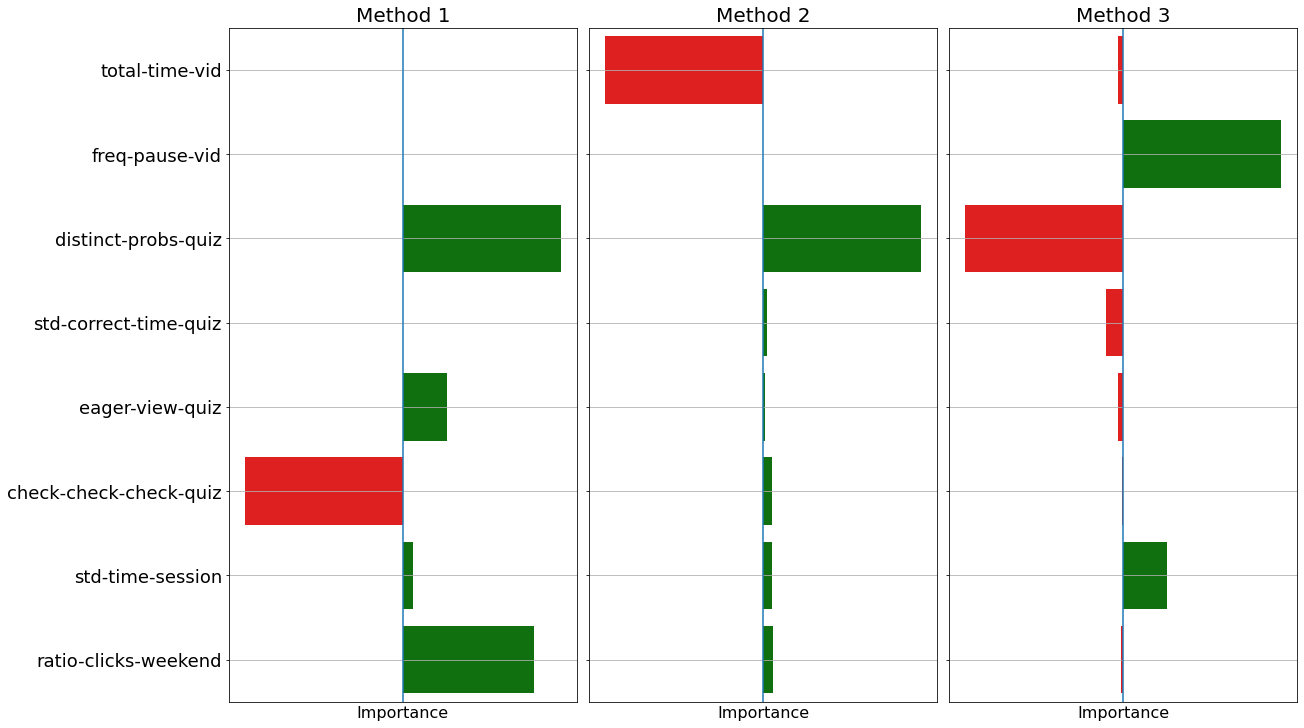

In [38]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
Geom['mean_norm_df'] = mean_norm_df
Geom['norm_lime_df'] = norm_lime_df
Geom['norm_cem_df'] = norm_cem_df
Geom['norm_shap_df'] = norm_shap_df
plot_pool_all(Geom, 'lime', 'cem', 'shap')

In [39]:
AN_2['mean_norm_df']

,feature,mean_score_shap,mean_score_cem,mean_score_lime
0,total_clicks_InWeek1,0.001872,0.002568,0.000000
1,number_sessions_InWeek1,0.002118,0.002087,0.000000
2,time_in__video_sum_InWeek1,0.001401,0.003075,0.000000
3,time_in__problem_sum_InWeek1,0.001526,0.003861,0.000000
4,video.pause-video.speedchange-video.play_InWeek1,0.000039,0.001402,0.000401
...,...,...,...,...
539,obs_duration_problem_var_InWeek8,0.001689,0.004576,0.000000
540,obs_duration_problem_amax_InWeek8,0.002049,0.003059,0.000000
541,time_sessions_length_InWeek8,0.002624,0.002234,0.000391
542,time_sessions_length_InWeek8,0.002624,0.002234,0.021436


### AN vs Geom

In [40]:
compare_per_mod, compare_feat_mod = compare_period(AN_2, Geom, 
                                                   list(range(1,3)), list(range(3, 7)), list(range(7,9)), 
                                                   list(range(1,6)), list(range(6, 11)), list(range(11,16)))

In [41]:
# display(compare_per_mod)
display(compare_feat_mod)
compare_feat_mod.to_csv("./visualization/compare_feature_AL.csv")
compare_per_mod.to_csv("./visualization/compare_period_AL.csv")

,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
3,content_anticipation,0.001743,0.000972,0.000422,0.001046,0.000076,0.000260,0.006353,0.002230,-0.001184
39,time_between_sessions_std,0.001807,0.000260,0.000570,0.000879,0.000805,0.001487,0.002502,0.001598,-0.000719
21,number_submissions_avg,0.001539,0.000692,0.002436,0.001556,0.000706,0.001537,0.004524,0.002256,-0.000700
14,frequency_action_Video.Play,0.001941,0.000256,0.000000,0.000732,0.001356,0.002626,0.000000,0.001327,-0.000595
41,time_in__video_sum,0.001648,0.001018,0.000000,0.000889,0.001305,0.002965,0.000000,0.001423,-0.000534
...,...,...,...,...,...,...,...,...,...,...
7,fraction_spent_entirety_Video.Play,0.001561,0.000481,0.007777,0.003273,0.000582,0.000165,0.001059,0.000602,0.002671
60,video.play-video.play-video.play,0.002379,0.002687,0.008647,0.004571,0.000128,0.000867,0.004430,0.001809,0.002762
1,competency_anticipation,0.002327,0.001723,0.006993,0.003681,0.000192,0.000109,0.001252,0.000518,0.003163
59,video.play-video.pause-video.load,0.001838,0.000295,0.010724,0.004286,0.001189,0.001258,0.000011,0.000820,0.003466


In [42]:
compare_per_mod[compare_per_mod['feature_clean'].isin(['content_anticipation', 'time_between_sessions_std', 
                                                       'video.play-video.pause-video.load', 
                                                      'video.pause-video.speedchange-video.play'])]

,period,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
3,end,content_anticipation,0.000000,0.001673,0.001687,0.001120,0.000000,0.000219,0.008455,0.002891,-0.001771
135,start,content_anticipation,0.002556,0.000244,0.000000,0.000933,0.000227,0.000291,0.006650,0.002390,-0.001456
39,end,time_between_sessions_std,0.001125,0.000190,0.002278,0.001198,0.000000,0.000067,0.007290,0.002452,-0.001254
171,start,time_between_sessions_std,0.001923,0.000492,0.000000,0.000805,0.001431,0.002475,0.000000,0.001302,-0.000497
69,mid,content_anticipation,0.002208,0.000986,0.000000,0.001065,0.000000,0.000270,0.003955,0.001408,-0.000344
105,mid,time_between_sessions_std,0.002091,0.000178,0.000000,0.000756,0.000985,0.001920,0.000217,0.001040,-0.000284
189,start,video.pause-video.speedchange-video.play,0.001273,0.001378,0.010915,0.004522,0.001251,0.005680,0.000000,0.002310,0.002212
125,mid,video.play-video.pause-video.load,0.002119,0.000231,0.007157,0.003169,0.001182,0.001201,0.000000,0.000794,0.002375
59,end,video.play-video.pause-video.load,0.000955,0.000659,0.010719,0.004111,0.001006,0.002455,0.000034,0.001165,0.002946
57,end,video.pause-video.speedchange-video.play,0.000069,0.001539,0.014323,0.005311,0.000786,0.001023,0.002799,0.001536,0.003774


# Flipped LA

In [43]:
course = 'epfl_algebrelineaire'
Flip_LA = dict()

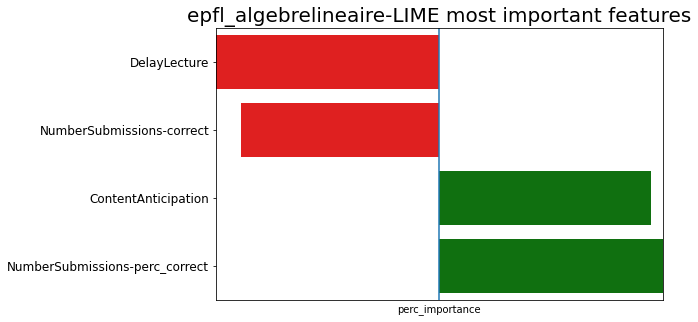

In [44]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
Flip_LA['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
Flip_LA['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
Flip_LA['lime_sort_df'] = lime_sort_df

**DelayLecture**: The average delay in viewing video lectures after they are released to students. \
**NumberSubmissions-correct**: The number of quizzes attempted and correct. \
**ContentAnticipation**: The number of videos covered by the student from those that are in subsequent weeks. \
**NumberSubmissions-perc_correct**:  The percentage of the correct quiz submissions with respect to the total submissions.

(99, 1148)
(99, 1150)


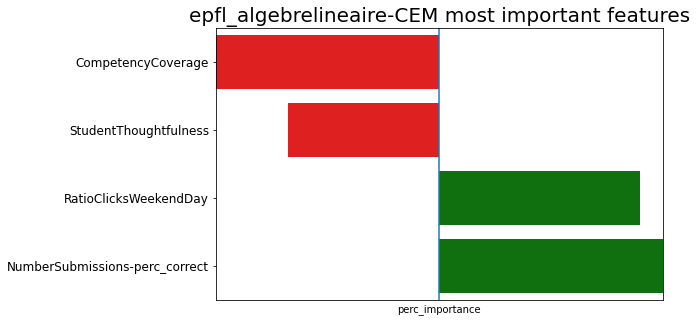

In [45]:
cem_df = load_cem_ori_res(course)
Flip_LA['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
Flip_LA['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
Flip_LA['cem_sort_df'] = cem_sort_df

**CompetencyCoverage**: The number of problems covered by the student since the beginning of the course \
**StudentThoughtfulness**: The amount of time passed reflecting on pause during a video \
**RatioClicksWeekendDay**: The ratio between clicks in weekdays and weekends. \
**NumberSubmissions-perc_correct**: The percentage of the correct quiz submissions with respect to the total submissions.

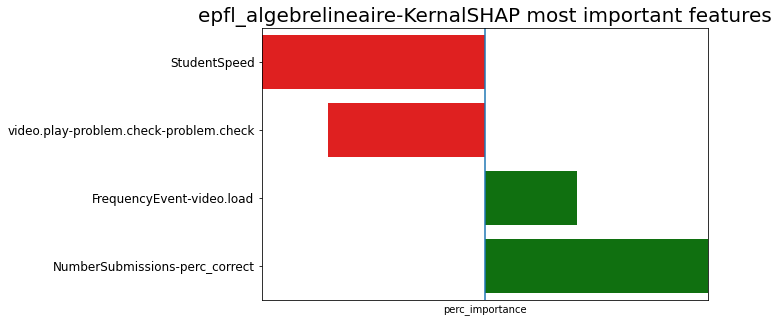

In [46]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
Flip_LA['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
Flip_LA['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
Flip_LA['shap_sort_df'] = shap_sort_df

**StudentSpeed**: The average time passed between two consecutive attempts for the same quiz. \
**Vplay-Qcheck-Qcheck**: The amount of times the student plays a video, then checks twice a quiz. \
**FrequencyEvent-video.load**: The frequency between every Video.Load action and the following action. \
**NumberSubmission-per_correct**: The percentage of the correct quiz submissions with respect to the total submissions.

In [47]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
Flip_LA['mean_norm_df'] = mean_norm_df
Flip_LA['norm_lime_df'] = norm_lime_df
Flip_LA['norm_cem_df'] = norm_cem_df
Flip_LA['norm_shap_df'] = norm_shap_df

# MOOC LA

In [48]:
course = 'epflx_algebre2x'
mooc_LA = dict()

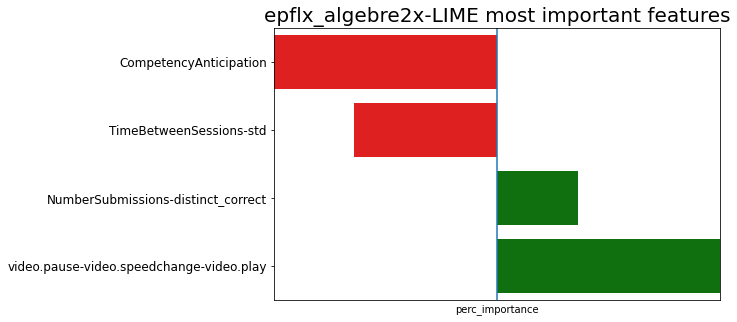

In [49]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
mooc_LA['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
mooc_LA['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
mooc_LA['lime_sort_df'] = lime_sort_df
# mooc_LA['lime_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
#                                                lime_sort_df, course, 'lime')

(100, 1296)
(100, 1298)


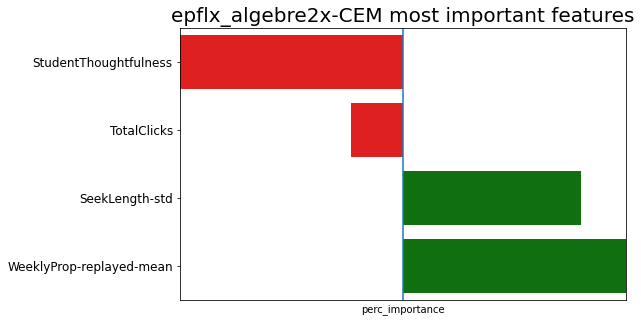

In [50]:
cem_df = load_cem_ori_res(course)
mooc_LA['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
mooc_LA['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
mooc_LA['cem_sort_df'] = cem_sort_df
# mooc_LA['cem_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
#                                                cem_sort_df, course, 'cem')

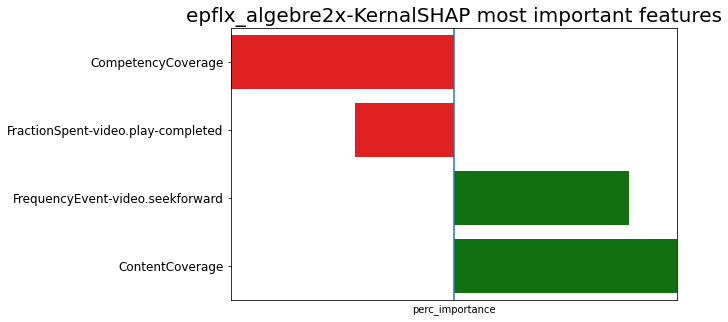

In [51]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
mooc_LA['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
mooc_LA['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
mooc_LA['shap_sort_df'] = shap_sort_df
# mooc_LA['shap_pool_sort_df'] = plot_pool_importance(AL_selected_features, 
#                                                shap_sort_df, course, 'shap')

In [52]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
mooc_LA['mean_norm_df'] = mean_norm_df
mooc_LA['norm_lime_df'] = norm_lime_df
mooc_LA['norm_cem_df'] = norm_cem_df
mooc_LA['norm_shap_df'] = norm_shap_df
# plot_pool_all(mooc_LA, 'lime', 'cem', 'shap')

## Flipped vs MOOC (Linear Algebra)

In [53]:
compare_per_mod, compare_feat_mod = compare_period(Flip_LA, mooc_LA, 
                                                   list(range(1,5)), list(range(5, 11)), list(range(11,15)), 
                                                   list(range(1,6)), list(range(6, 12)), list(range(12,17)))
compare_feat_mod.to_csv("./visualization/compare_feature_md_LA.csv")
compare_per_mod.to_csv("./visualization/compare_period_md_LA.csv")

In [54]:
head = compare_feat_mod.head(2)
tail = compare_feat_mod.tail(2)
head.append(tail)

,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
1,CompetencyAnticipation,0.000770,0.000069,0.001760,0.000867,0.000674,0.000171,0.010114,0.003653,-0.002787
9,FractionSpent-video.play-completed,0.000678,0.000867,0.000386,0.000643,0.000794,0.000264,0.007623,0.002894,-0.002250
0,AttendanceRate,0.000731,0.000561,0.003636,0.001643,0.000803,0.000044,0.000226,0.000358,0.001285
67,WatchingIndex,0.000706,0.000770,0.004209,0.001895,0.000779,0.000481,0.000026,0.000429,0.001466


In [55]:
compare_per_mod[compare_per_mod['feature_clean'].isin(['CompetencyAnticipation', 
                                                       'FractionSpent-video.play-completed', 
                                                       'AttendanceRate', 'WatchingIndex'])]

,period,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
1,end,CompetencyAnticipation,0.000000,0.000015,0.002715,0.000910,0.000747,0.000066,0.013690,0.004834,-0.003924
82,mid,CompetencyAnticipation,0.000888,0.000095,0.002220,0.001068,0.000783,0.000203,0.012204,0.004397,-0.003329
90,mid,FractionSpent-video.play-completed,0.001032,0.001660,0.000000,0.000897,0.000921,0.000368,0.011231,0.004173,-0.003276
9,end,FractionSpent-video.play-completed,0.000000,0.000000,0.001351,0.000450,0.000844,0.000102,0.008315,0.003087,-0.002637
163,start,CompetencyAnticipation,0.001335,0.000079,0.000000,0.000471,0.000470,0.000239,0.004031,0.001580,-0.001109
171,start,FractionSpent-video.play-completed,0.000824,0.000544,0.000000,0.000456,0.000590,0.000301,0.002602,0.001164,-0.000708
229,start,WatchingIndex,0.001132,0.000710,0.000000,0.000614,0.001063,0.001513,0.000000,0.000859,-0.000245
162,start,AttendanceRate,0.001056,0.000226,0.000000,0.000427,0.000867,0.000096,0.000178,0.000380,0.000047
81,mid,AttendanceRate,0.001124,0.001252,0.000000,0.000792,0.000737,0.000031,0.000409,0.000392,0.000400
148,mid,WatchingIndex,0.000893,0.001323,0.000000,0.000739,0.000623,0.000009,0.000045,0.000226,0.000513


# African City 1

In [56]:
course = 'villesafricaines_001'
AC_1 = dict()

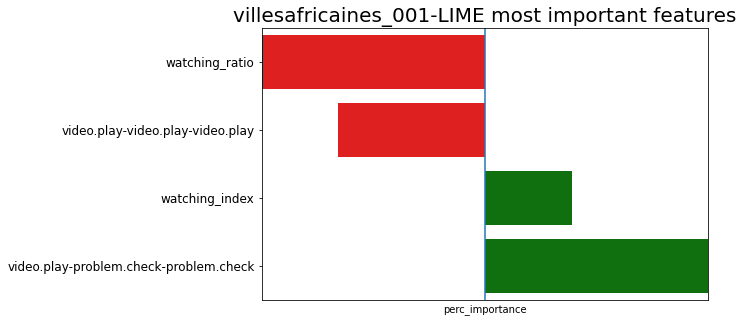

In [57]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
AC_1['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
AC_1['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
AC_1['lime_sort_df'] = lime_sort_df

(100, 793)
(100, 795)


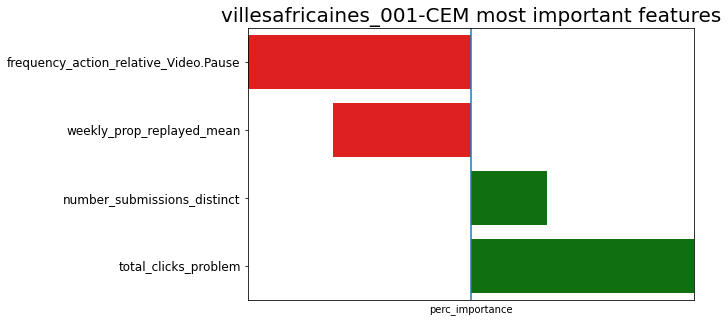

In [58]:
cem_df = load_cem_ori_res(course)
AC_1['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
AC_1['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
AC_1['cem_sort_df'] = cem_sort_df

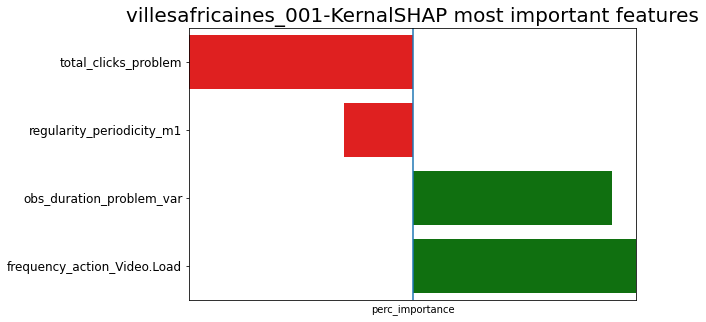

In [59]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
AC_1['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
AC_1['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
AC_1['shap_sort_df'] = shap_sort_df

In [60]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
AC_1['mean_norm_df'] = mean_norm_df
AC_1['norm_lime_df'] = norm_lime_df
AC_1['norm_cem_df'] = norm_cem_df
AC_1['norm_shap_df'] = norm_shap_df

# African City 2

In [61]:
course = 'villesafricaines_002'
AC_2 = dict()

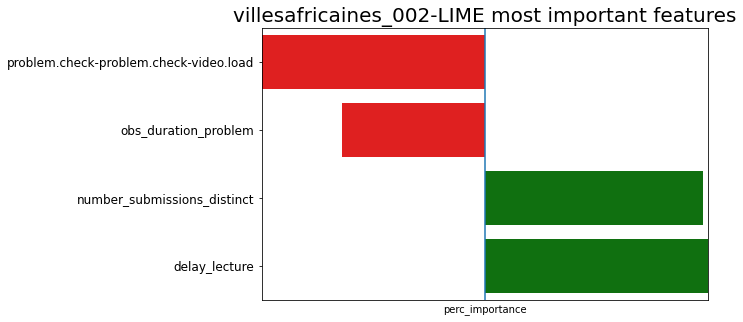

In [62]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
AC_2['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
AC_2['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
AC_2['lime_sort_df'] = lime_sort_df

(100, 780)
(100, 782)


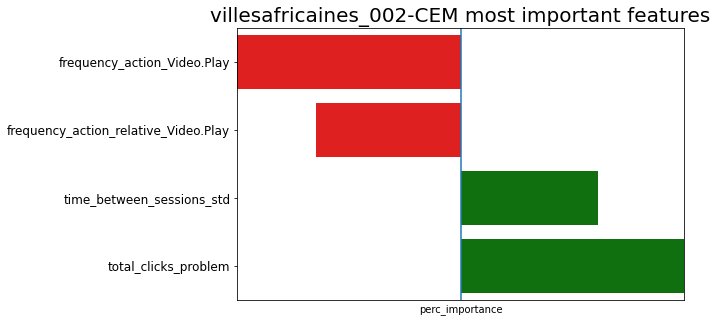

In [63]:
cem_df = load_cem_ori_res(course)
AC_2['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
AC_2['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
AC_2['cem_sort_df'] = cem_sort_df

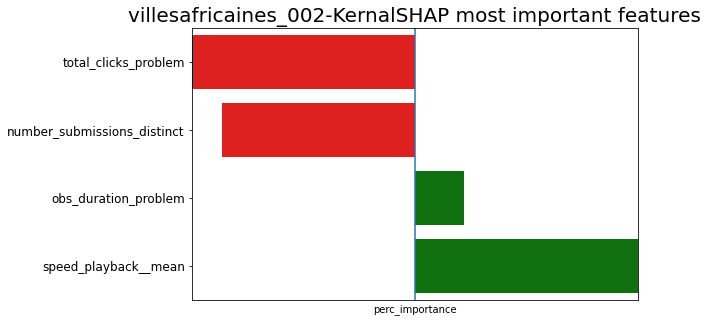

In [64]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
AC_2['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
AC_2['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
AC_2['shap_sort_df'] = shap_sort_df

In [65]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
AC_2['mean_norm_df'] = mean_norm_df
AC_2['norm_lime_df'] = norm_lime_df
AC_2['norm_cem_df'] = norm_cem_df
AC_2['norm_shap_df'] = norm_shap_df

## African city 001 vs 002

In [66]:
compare_per_mod, compare_feat_mod = compare_period(AC_1, AC_2, 
                                                   list(range(1,5)), list(range(5, 10)), list(range(10,14)), 
                                                   list(range(1,5)), list(range(5, 9)), list(range(9,13)))
compare_feat_mod.to_csv("./visualization/compare_feature_demo.csv")
compare_per_mod.to_csv("./visualization/compare_period_demo.csv")
head = compare_feat_mod.head(2)
tail = compare_feat_mod.tail(2)
head.append(tail)

,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
4,fraction_spent_completed_Video.Play,0.001087,0.001155,0.001381,0.001208,0.000764,0.001923,0.005842,0.002843,-0.001635
32,student_speed,0.001586,0.001844,0.000000,0.001143,0.001741,0.001603,0.003093,0.002146,-0.001002
57,weekly_prop_interrupted_mean,0.001123,0.000764,0.005281,0.002389,0.001038,0.000866,0.001566,0.001157,0.001233
56,watching_ratio,0.000964,0.000227,0.004929,0.002040,0.001094,0.000366,0.000866,0.000775,0.001265


In [67]:
compare_per_mod[compare_per_mod['feature_clean'].isin(['fraction_spent_completed_Video.Play', 
                                                       'student_speed', 
                                                       'weekly_prop_interrupted_mean', 
                                                       'watching_ratio'])]

,period,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
4,end,fraction_spent_completed_Video.Play,0.000000,0.000000,0.004487,0.001496,0.000011,0.000941,0.017526,0.006159,-0.004664
32,end,student_speed,0.001449,0.002274,0.000000,0.001241,0.002156,0.000906,0.008043,0.003701,-0.002460
124,start,fraction_spent_completed_Video.Play,0.001458,0.001788,0.000000,0.001082,0.001329,0.002450,0.000000,0.001260,-0.000178
152,start,student_speed,0.001511,0.001512,0.000000,0.001008,0.001385,0.002146,0.000000,0.001177,-0.000169
176,start,watching_ratio,0.001286,0.000034,0.000000,0.000440,0.001661,0.000079,0.000000,0.000580,-0.000140
116,mid,watching_ratio,0.001477,0.000105,0.000000,0.000527,0.001203,0.000606,0.000000,0.000603,-0.000076
177,start,weekly_prop_interrupted_mean,0.001507,0.000789,0.000000,0.000765,0.001300,0.001181,0.000000,0.000827,-0.000061
64,mid,fraction_spent_completed_Video.Play,0.001661,0.001574,0.000000,0.001078,0.000951,0.002377,0.000000,0.001109,-0.000031
92,mid,student_speed,0.001755,0.001766,0.000000,0.001174,0.001579,0.001931,0.000000,0.001170,0.000004
117,mid,weekly_prop_interrupted_mean,0.001714,0.001320,0.000000,0.001011,0.001443,0.001252,0.000000,0.000899,0.000113


# AN 1

In [68]:
course = 'analysenumerique_001'
AN_1 = dict()

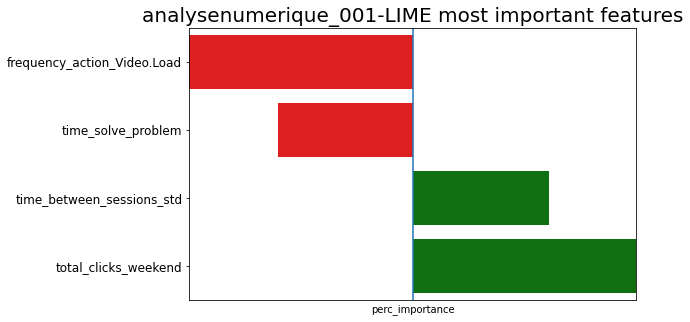

In [69]:
lime_df = dataframe_all_lime(folder, course)
lime_df.drop(['exp number', 'real value'], axis = 1, inplace = True) 
AN_1['lime_df'] = lime_df
lime_df.columns = clean_lime_col_name(lime_df.columns)
lime_mean_df = construct_mean_df(lime_df)
AN_1['lime_mean_df'] = lime_mean_df
lime_sort_df = plot_top2(lime_mean_df, 'LIME', course)
AN_1['lime_sort_df'] = lime_sort_df

(99, 387)
(99, 389)


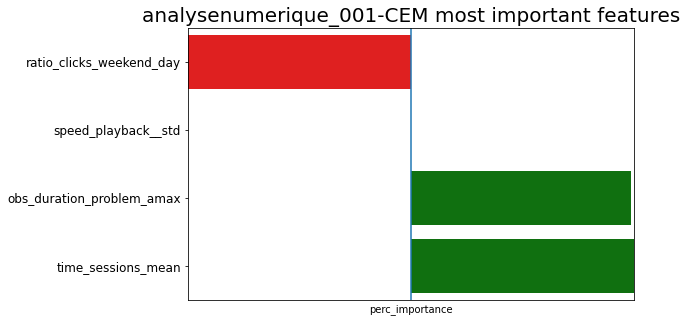

In [70]:
cem_df = load_cem_ori_res(course)
AN_1['cem_df'] = cem_df
mean_cem_df = construct_mean_df(cem_df)
AN_1['cem_mean_df'] = mean_cem_df
cem_sort_df = plot_top2(mean_cem_df, 'CEM', course)
AN_1['cem_sort_df'] = cem_sort_df

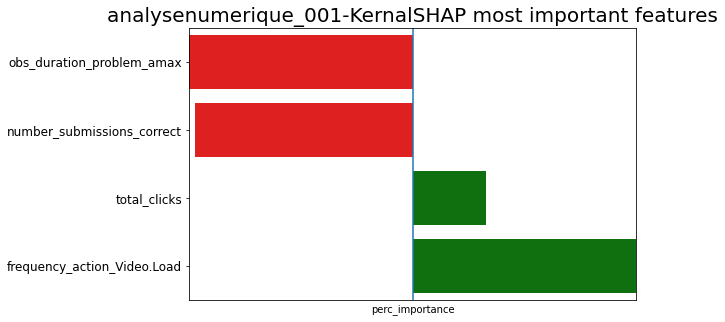

In [71]:
extract_file = folder + "/SHAP/" + course + "/kernel/" + course + ".csv"
shap_df = pd.read_csv(extract_file, header=0)
shap_df.drop(['Unnamed: 0', 'exp_num'], axis = 1, inplace = True) 
AN_1['shap_df'] = shap_df
shap_df_mean = construct_mean_df(shap_df)
AN_1['shap_mean_df'] = shap_df_mean
shap_sort_df = plot_top2(shap_df_mean, method='KernalSHAP', course=course)
AN_1['shap_sort_df'] = shap_sort_df

In [72]:
mean_norm_df, norm_lime_df, norm_cem_df, norm_shap_df = get_mean_score_norm(lime_df, shap_df, cem_df)
AN_1['mean_norm_df'] = mean_norm_df
AN_1['norm_lime_df'] = norm_lime_df
AN_1['norm_cem_df'] = norm_cem_df
AN_1['norm_shap_df'] = norm_shap_df

## AN 1 vs 2

In [73]:
AN_2['cem_df']

,total_clicks_InWeek1,number_sessions_InWeek1,time_in__video_sum_InWeek1,time_in__problem_sum_InWeek1,video.pause-video.speedchange-video.play_InWeek1,video.play-video.pause-video.load_InWeek1,video.play-video.play-video.play_InWeek1,video.play-problem.check-problem.check_InWeek1,problem.check-problem.check-video.load_InWeek1,problem.check-problem.check-problem.check_InWeek1,...,number_submissions_InWeek8,number_submissions_distinct_correct_InWeek8,number_submissions_avg_InWeek8,obs_duration_problem_InWeek8,number_submissions_perc_correct_InWeek8,time_solve_problem_InWeek8,obs_duration_problem_var_InWeek8,obs_duration_problem_amax_InWeek8,time_sessions_length_InWeek8,number_submissions_correct_InWeek8
0,5.743516e-11,-1.823967e-10,2.003059e-10,-9.576049e-11,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,2.010699e-02,0.0,0.000000,0.0,0.001344,9.079246e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.001097
1,-6.133004e-12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,2.100977e-02,0.0,0.000000,0.0,0.001085,4.559106e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000629
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,2.218965e-02,0.0,0.000000,0.0,0.001041,4.812862e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
3,2.871758e-11,-1.823967e-10,0.000000e+00,1.575825e-13,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,2.181681e-02,0.0,0.000000,0.0,0.001016,4.826788e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,...,2.005808e-02,0.0,0.000000,0.0,0.001022,4.302224e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-9.620969e-10,-1.836022e-09,5.537707e-10,1.392640e-09,0.000586,0.000000e+00,0.000000e+00,0.0,0.0,-5.081043e-10,...,0.000000e+00,0.0,0.000000,0.0,0.000000,2.127129e-10,-2.905102e-10,-2.957783e-09,9.451948e-09,0.000000
96,8.615274e-10,4.009578e-10,3.683179e-09,1.705852e-09,0.003700,0.000000e+00,0.000000e+00,0.0,0.0,-2.540521e-10,...,0.000000e+00,0.0,0.000000,0.0,0.000000,-4.691155e-11,6.104699e-11,2.288859e-09,9.451948e-09,0.000000
97,8.615274e-11,-1.823967e-10,0.000000e+00,-2.116584e-10,0.001172,0.000000e+00,0.000000e+00,0.0,0.0,2.624474e-10,...,0.000000e+00,0.0,0.000946,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
98,4.766951e-12,-1.836022e-09,4.182342e-10,2.880980e-10,0.007396,9.937578e-10,1.952581e-10,0.0,0.0,0.000000e+00,...,2.484565e-09,0.0,0.005101,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000


In [74]:
compare_per_mod, compare_feat_mod = compare_period(AN_1, AN_2, 
                                                   list(range(1,4)), list(range(4, 7)), list(range(7,10)), 
                                                   list(range(1,3)), list(range(3, 7)), list(range(7,9)))

compare_feat_mod.to_csv("./visualization/compare_feature_PR.csv")
compare_per_mod.to_csv("./visualization/compare_period_PR.csv")

head = compare_feat_mod.head(2)
tail = compare_feat_mod.tail(2)
head.append(tail)

,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
17,obs_duration_problem_var,0.002822,0.000620,0.001519,0.001654,0.001780,0.003269,0.002681,0.002576,-0.000922
12,number_submissions_distinct,0.003134,0.001481,0.002749,0.002455,0.002412,0.002237,0.004609,0.003086,-0.000632
24,speed_playback__std,0.001778,0.000000,0.008991,0.003589,0.001826,0.002370,0.000000,0.001399,0.002191
10,number_submissions_avg,0.002759,0.004787,0.003937,0.003828,0.001539,0.000692,0.002436,0.001556,0.002272


In [75]:
compare_per_mod[compare_per_mod['feature_clean'].isin(['obs_duration_problem_var', 
                                                       'number_submissions_distinct', 
                                                       'speed_playback__std', 
                                                       'number_submissions_avg'])]

,period,feature_clean,mean_score_shap_1,mean_score_cem_1,mean_score_lime_1,mean_score_1,mean_score_shap_2,mean_score_cem_2,mean_score_lime_2,mean_score_2,diff
12,end,number_submissions_distinct,0.003850,0.002767,0.006048,0.004222,0.002572,0.001664,0.011522,0.005253,-0.001031
98,start,number_submissions_distinct,0.002875,0.000144,0.000000,0.001006,0.002191,0.002992,0.000000,0.001728,-0.000721
60,mid,obs_duration_problem_var,0.002843,0.000510,0.004558,0.002637,0.001666,0.003045,0.005361,0.003357,-0.000720
17,end,obs_duration_problem_var,0.002179,0.000806,0.000000,0.000995,0.001912,0.003135,0.000000,0.001682,-0.000687
55,mid,number_submissions_distinct,0.002199,0.000673,0.000000,0.000958,0.002363,0.002433,0.000000,0.001599,-0.000641
103,start,obs_duration_problem_var,0.003446,0.000543,0.000000,0.001330,0.001875,0.003849,0.000000,0.001908,-0.000578
67,mid,speed_playback__std,0.001218,0.000000,0.008294,0.003171,0.001915,0.002729,0.000000,0.001548,0.001623
96,start,number_submissions_avg,0.002765,0.005338,0.000000,0.002701,0.002030,0.000473,0.000000,0.000834,0.001867
10,end,number_submissions_avg,0.002719,0.003313,0.011811,0.005948,0.000861,0.001076,0.009744,0.003894,0.002054
53,mid,number_submissions_avg,0.002793,0.005710,0.000000,0.002834,0.001633,0.000609,0.000000,0.000747,0.002087
